In [1]:
using Random, Statistics, PyPlot, Polynomials

In [2]:
struct Point2D
    x::Int64
    y::Int64
end

struct SquareLattice
    Nx::Int64
    Ny::Int64    
end

import Base.length
function length(lat::SquareLattice)
    return lat.Nx*lat.Ny
end

function PointToIndex(lat::SquareLattice, r::Point2D)
    @assert r.x <= lat.Nx "Site x coordinate exceeding lattice length"
    @assert r.y <= lat.Ny "Site y coordinate exceeding lattice width"
    
    return (r.y-1)*lat.Nx + r.x
end

function IndexToPoint(lat::SquareLattice, ind::Int64)
    
    @assert ind <= length(lat) "Site index exceeding lattice size"
    
    y = div(ind-1, lat.Nx)+1
    x = mod(ind-1, lat.Nx)+1

    return Point2D(x,y)
end
    
function NearestNeighbors(lat::SquareLattice, ind::Int64)

    r = IndexToPoint(lat, ind)
    
    nn = zeros(Int64,4)
    
    xp = mod(r.x, lat.Nx)+1
    yp = mod(r.y, lat.Ny)+1
    xm = mod(r.x-2, lat.Nx)+1
    ym = mod(r.y-2, lat.Ny)+1
    
    nn[1] = PointToIndex(lat, Point2D(xm, r.y) )
    nn[2] = PointToIndex(lat, Point2D(xp, r.y) )
    nn[3] = PointToIndex(lat, Point2D(r.x, ym) )
    nn[4] = PointToIndex(lat, Point2D(r.x, yp) )
    
    return nn
end

NearestNeighbors (generic function with 1 method)

In [3]:
function CalculateError(m, Neq, Nsw)
    err = Float64[]
    Nsw2 = 2^Int(floor(log(2, Nsw-Neq))) # closest power of 2 smaller than number of sweeps after equilibration
    ml = m[end-Nsw2+1:end]
    min_size = 2^5
    while length(ml) > min_size
        push!(err, std(ml)/sqrt(length(ml)-1))
        ml = map(j -> mean(ml[2*j-1:2*j]), range(1,stop=div(length(ml),2)) )
    end
    return err
end

CalculateError (generic function with 1 method)

# Cluster updates

In [4]:
function IsingConfigurationEnergy(lat::SquareLattice, c::Vector{Int64})
    
    N = length(lat)
    @assert N == length(c) "Configuration incompatible with lattice size"
    
    Ec = 0.
    
    for j in range(1, length = N)
        nn = NearestNeighbors(lat, j)
        Ec += -4*(c[j]-1/2)*sum(c[nn].-1/2)
    end
    return Ec/2 # in the summation above every bond is included twice
end

IsingConfigurationEnergy (generic function with 1 method)

In [5]:
function IsingWolffUpdate!(lat::SquareLattice, c::Vector{Int64}, T::Float64)

    N = length(lat)
    
    @assert N == length(c) "Configuration incompatible with lattice size"
    
    p = 1. - exp(-2/T)
            
    ind = rand(1:N) # pick a random site

    cluster = Int64[] # indices of spins in the cluster
    newlyAdded = Int64[] # indices of newly added neighbors

    push!(cluster, ind)
    append!(newlyAdded, NearestNeighbors(lat, ind))

    while !isempty(newlyAdded)
        j = pop!(newlyAdded)
        if j in cluster
            continue
        end
        if c[j] == c[ind] && rand() < p
            push!(cluster, j)
            nn = NearestNeighbors(lat, j)
            append!(newlyAdded, nn)
        end
    end

    c[cluster] = 1 .- c[cluster] # flip the cluster
end

IsingWolffUpdate! (generic function with 1 method)

In [6]:
function IsingMC_Wolf(lat::SquareLattice, T::Float64, Nsw::Int64)
    # Nsw is the number of sweeps to perform
    
    c = rand(0:1, length(lat))

    
    m = zeros(Float64, Nsw) # absolute value of the magnetization per site
    m[1] = abs( mean(2*c .- 1) )
    
    En = zeros(Float64, Nsw)
    En[1] = IsingConfigurationEnergy(lat, c)
    
    for i in range(2, stop=Nsw)
        
        IsingWolffUpdate!(lat, c, T)
        En[i] = IsingConfigurationEnergy(lat, c)

        m[i] =  abs( mean(2*c .- 1) )

    end
    
    return m, En
    
end

IsingMC_Wolf (generic function with 1 method)

# Worm algorithm

In [7]:
function IsingMC_Worm(lat::SquareLattice, T::Float64, Neq::Int64, Ns::Int64)
    # Ns is the number of full loop updates after which we stop, upon completion this is the same as Z!
    # Neq is the number of equilibration steps, don't measure G1, G during these steps
    # Do measure Nl to check that actual equilibration time is consistent with Neq
    
    # configuration n_b=0,1 for each bond:
    # number of bonds = number of sites * 2 bonds per site (1 = vertical, 2 = horizontal)
    c = zeros(length(lat), 2) 
    
    Ira, Masha = 0,0
    
    Nc, G1, G = 0, 0, 0
    Nl = zeros(Neq+Ns) # the total length of all loops (\sum n_b) sampled every time we reach a closed loop configuration 
    
    while Nc<(Neq+Ns)
        if Ira == Masha
            # Jump to new random point
            i0 = rand(1:length(lat))
            r0 = IndexToPoint(lat, i0)
            Ira, Masha = r0, r0 
        end
        
        # Attempt to move Masha
        new_x, new_y = Masha.x, Masha.y
        bond = rand(1:4) # pick random direction, bonds indexed clock-wise starting from "12"
        if bond == 1 # move up
            new_y = mod(Masha.y, lat.Ny)+1
            ind_b = PointToIndex(lat, Masha)
            b = 1
        elseif bond == 2 # move right
            new_x = mod(Masha.x, lat.Nx)+1
            ind_b = PointToIndex(lat, Masha)
            b = 2
        elseif bond == 3 # move down
            new_y = mod(Masha.y-2, lat.Ny)+1
            ind_b = PointToIndex(lat, Point2D(new_x,new_y))
            b = 1
            else # move left
            new_x = mod(Masha.x-2, lat.Nx)+1
            ind_b = PointToIndex(lat, Point2D(new_x,new_y))
            b = 2
        end
        
        nb = c[ind_b, b] # current configuration of the bond along which Masha moves
        
        # Accept move with probability p = min(1, tanh(beta)) for Nb = 0, min(1, 1/tanh(beta)) for Nb = 1
        p = nb==0 ? tanh(1/T) : 1 # 1/tanh(beta) > 1 => for Nb=1 always accept
        if rand() < p # Accept move
            Masha = Point2D(new_x,new_y)
            c[ind_b, b] = 1- c[ind_b, b]
        end
            
        if Ira == Masha 
            Nc += 1 # this configuration contributes to the partition function
            Nl[Nc] = sum(c)
        elseif ( Ira.y==Masha.y && (abs(Ira.x-Masha.x) == 1 || abs(Ira.x-Masha.x) == lat.Nx-1) ) || 
            ( Ira.x==Masha.x && (abs(Ira.y-Masha.y) == 1 || abs(Ira.y-Masha.y) == lat.Ny-1) )
            # dist between Ira and Masha is 1 => 
            # this configuration contributes to the nearest-neighbor correlation function
            if Nc>Neq
                G1 +=1
            end
        end
        
        if Nc>Neq
            G += 1
        end
    end 
    
    return G1, G, Nl
    
end

IsingMC_Worm (generic function with 1 method)

## Test energy per bond vs Wolff cluster updates

In [8]:
lat = SquareLattice(8,8)
Nb = length(lat)*2 # total number of bonds
T = 2.
Nsw = 10000
@time m,En = IsingMC_Wolf(lat, T, Nsw);

  0.240559 seconds (2.62 M allocations: 310.677 MiB, 15.05% gc time)


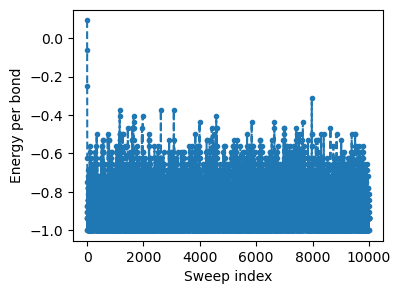

In [9]:
figure(figsize=(4,3))
plot(En/Nb, "--.") # energy per bond
xlabel("Sweep index")
ylabel("Energy per bond");

In [10]:
E_bond = mean(En[1000:end])/Nb
err = CalculateError(En/Nb, 1000, Nsw)
dE = err[end]
println("Energy per bond using Wolff cluster updates is ", round(E_bond, digits=3), " +- ", round(dE,sigdigits=1))

Energy per bond using Wolff cluster updates is -0.874 +- 0.002


In [11]:
Neq, Z = 1000, 100000
@time G1, G, Nl = IsingMC_Worm(lat, T, Neq, Z);

  0.309108 seconds (5 allocations: 790.312 KiB)


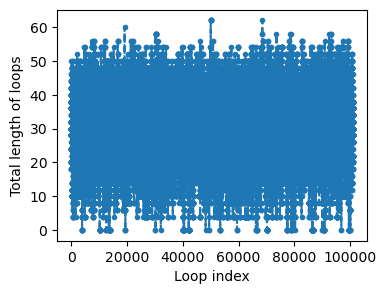

In [12]:
figure(figsize=(4,3))
plot(Nl, "--.") # energy per bond
xlabel("Loop index")
ylabel("Total length of loops");

Autocorrelation time: 10.0


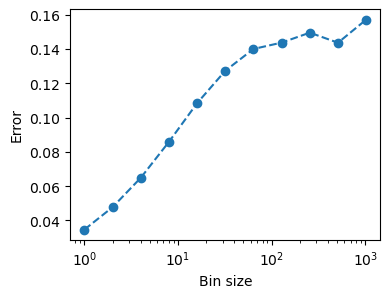

In [13]:
err = CalculateError(Nl, Neq, Neq+Z)
println("Autocorrelation time: ", round(((err[end]/err[1])^2-1)/2) )
figure(figsize=(4,3))
plot(2 .^ range(0, length= length(err)), err, "--o")
ylabel("Error")
xlabel("Bin size")
xscale("log")

In [15]:
beta = 1/T
mean_Nl_norm = mean(Nl/Nb)
E_bond = -tanh(beta)*(1+mean_Nl_norm/sinh(beta)^2)
dE = -tanh(beta)*err[end]/Nb/sinh(beta)^2
println("Energy per bond using Worm algorithm is ", round(E_bond, digits=3), " +- ", round(dE,sigdigits=1))

Energy per bond using Worm algorithm is -0.87 +- -0.002


In [16]:
E_bond = -G1/Z/4 # G1 was summed over the 4 nearest-neighbors, so here consider the average
println("Energy per bond using n-n correlations in Worm algorithm is ", round(E_bond, digits=3))

Energy per bond using n-n correlations in Worm algorithm is -0.875


## Scaling of the auto-correlation time

In [101]:
Ls = Int64[8, 16, 24, 32]
Ts = range(0.4, stop=4., step=0.2)

Neq = Int64[1000, 1000, 2000, 2000]
Ntot = Neq*100

En = zeros(length(Ts), length(Ls))
dEn = zeros(length(Ts), length(Ls))
m2 = zeros(length(Ts), length(Ls))
tau = zeros(length(Ts), length(Ls))

for (j, L) in enumerate(Ls)
    lat = SquareLattice(L,L)
    Nb = 2*length(lat)
    for (k, T) in enumerate(Ts)
        G1, G, Nl = IsingMC_Worm(lat, T, Neq[j], Ntot[j]);
        Z = Ntot[j]
        m2[k,j] = 1/(Z/G)/length(lat)
        err = CalculateError(Nl, Neq[j], Ntot[j])
        tau[k,j] = ((err[end]/err[1])^2-1)/2
    end
end


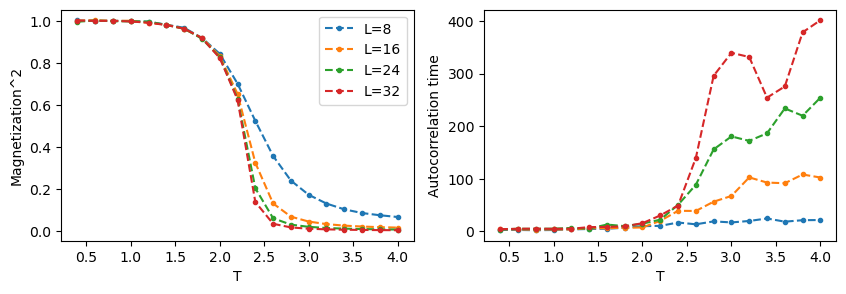

PyObject <matplotlib.legend.Legend object at 0x7f830815cd30>

In [102]:
fig, ax = subplots(1,2, figsize=(10,3))
for (j, L) in enumerate(Ls)
    ax[1].plot(Ts,m2[:,j], "--.", label="L="*string(L))
end
ax[1].set_xlabel("T")
ax[1].set_ylabel("Magnetization^2");

ax[2].plot(Ts, tau, "--.")
ax[2].set_xlabel("T")
ax[2].set_ylabel("Autocorrelation time");

ax[1].legend()


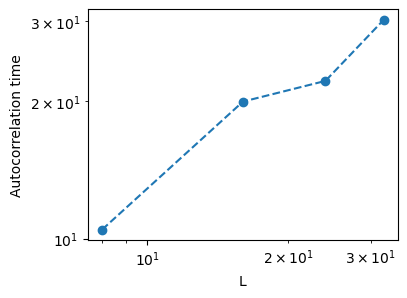

Dynamical critical exponent using Worm algorithm is 0.73


In [103]:
ind_Tc = 10
figure(figsize=(4,3))
plot(Ls, tau[ind_Tc,:], "--o")
xlabel("L")
ylabel("Autocorrelation time");
xscale("log")
yscale("log")

p = fit(log.(Ls), log.(tau[ind_Tc,:]), 1)
println("Dynamical critical exponent using Worm algorithm is ", round(p[1],digits = 2))